In [1]:
import os, json, csv
from datetime import datetime
from multiprocessing import Pool
from tpascat import Scattering, Utils, Sampler
from tqdm import tqdm # type: ignore

In [2]:
def create_json_files(base_dir, pulsars, output_dir, nchan=8, DMr=[362, 364], Tau_sc=[-3, -1], 
                      Tau_idx=[-4, -2], incScatter=True, incScatter_index=True, 
                      Nshapelets=1, have_EFAC=False, EFAC=[0.5, 10]):
    """
    Create JSON files for different pulsar observations based on a directory structure.

    Parameters:
    - base_dir (str): Base directory where pulsar data is stored (e.g., /project/gravwave/Data/TPA).
    - pulsars (list): List of pulsar names to process (e.g., ['J1818-1422', 'J1909-3744']).
    - output_dir (str): Directory to store the generated JSON files.
    - Other parameters correspond to the default values used in the JSON template.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    for pulsar in pulsars:
        pulsar_dir = os.path.join(base_dir, pulsar)
        
        # Loop through the epochs in each pulsar's directory
        if os.path.exists(pulsar_dir):
            for epoch in sorted(os.listdir(pulsar_dir)):
                epoch_dir = os.path.join(pulsar_dir, epoch)
                
                # Look for subdirectories such as '1', '2', etc.
                if os.path.isdir(epoch_dir):
                    for sub_dir in os.listdir(epoch_dir):
                        sub_dir_path = os.path.join(epoch_dir, sub_dir)
                        
                        if os.path.isdir(sub_dir_path):
                            decimated_dir = os.path.join(sub_dir_path, "decimated")
                            
                            # Check if the 'decimated' folder exists
                            if os.path.exists(decimated_dir):
                                # Find the observation file in the 'decimated' folder
                                for file in os.listdir(decimated_dir):
                                    if file.endswith(".16ch_1p_1t.ar"):
                                        filepath = os.path.join(decimated_dir, file)
                                        
                                        # Create the dictionary for the JSON data
                                        json_data = {
                                            "filepath": filepath,
                                            "nchan": nchan,
                                            "DMr": DMr,
                                            "Tau_sc": Tau_sc,
                                            "Tau_idx": Tau_idx,
                                            "incScatter": incScatter,
                                            "incScatter_index": incScatter_index,
                                            "Nshapelets": Nshapelets,
                                            "have_EFAC": have_EFAC,
                                            "EFAC": EFAC
                                        }
                                        
                                        # Define the output JSON filename
                                        json_filename = f"{pulsar}_{epoch}.json"
                                        output_path = os.path.join(output_dir, json_filename)
                                        
                                        # Write the JSON file
                                        with open(output_path, 'w') as json_file:
                                            json.dump(json_data, json_file, indent=2)
                                        
                                        print(f"Created JSON: {output_path}")

json_output_dir = "/project/gravwave/Data/TPASCAT/jsons"
pulsars = ["J1818-1422"]
base_dir = "/project/gravwave/Data/TPA"
create_json_files(base_dir,pulsars,json_output_dir)

Created JSON: /project/gravwave/Data/TPASCAT/jsons/J1818-1422_2019-03-08-05:11:53.json
Created JSON: /project/gravwave/Data/TPASCAT/jsons/J1818-1422_2019-11-03-09:07:13.json
Created JSON: /project/gravwave/Data/TPASCAT/jsons/J1818-1422_2019-12-01-14:28:54.json
Created JSON: /project/gravwave/Data/TPASCAT/jsons/J1818-1422_2020-02-24-04:18:22.json
Created JSON: /project/gravwave/Data/TPASCAT/jsons/J1818-1422_2020-03-29-04:45:36.json
Created JSON: /project/gravwave/Data/TPASCAT/jsons/J1818-1422_2021-12-23-12:07:42.json


In [6]:
def extract_date_from_filepath(filepath):
    # Assuming the date is embedded in the filepath like "2019-03-08-05:11:53"
    date_str = filepath.split('/')[-4]
    return datetime.strptime(date_str, '%Y-%m-%d-%H:%M:%S').date()

# Function to process a single pulsar
def process_pulsar(json_file, results_path):
    # Initialize the Utils class to load the parameters from the JSON file
    utils = Utils(json_file)
    
    # Extract parameters for the Scattering class
    scatter_params = utils.get_scattering_parameters()
    if scatter_params is None:
        print(f"Failed to get scattering parameters for {json_file}")
        return
    
    # Extract priors for the Scattering model
    priors = utils.get_priors()
    if priors is None:
        print(f"Failed to get priors for {json_file}")
        return
    
    # Initialize the Scattering model
    model = Scattering(**scatter_params)
    model.set_pDM(priors['pDM'])
    model.set_pSc(priors['pSc'])
    model.set_pSci(priors['pSci'])
    model.set_pEFAC(priors['pEFAC'])
    
    # Align profiles to Reference frequency profile
    model.prof_to_ref_freq()

    # Get the number of dimensions and parameter names
    Ndim, paramnames = utils.get_ndims_and_paramnames()
    
    # Set up the sampler
    sampler = Sampler(paramnames, model.LogLikelihood, model.Prior,min_num_live_points=200)
    sampler.setup_sampler(filepath=scatter_params['filepath'], Ndim=Ndim, 
                          base_logdir="/project/gravwave/Data/TPASCAT/nested_runs")
    
    # Run the sampler
    sampler.run_sampler()

    #Saving the corner plot for each pulsar-epoch
    filename_base = os.path.splitext(os.path.basename(json_file))[0]
    plot_path = os.path.join(results_path, f"{filename_base}_corner_plot.png")
    sampler.plot_corner_scattering(plot_path)  #if plot_path is None, it will display the plot here.
    
    
    # Use output_text_summary to get scattering parameter statistics
    tau_mean, tau_lower, tau_upper, index_mean, index_lower, index_upper = sampler.output_text_summary()

    # Extract the pulsar name from the filepath
    pulsar_name = scatter_params['filepath'].split('/')[-4]  # Assumes pulsar name is in the path
    
    # Define the output CSV file for the pulsar
    csv_filename = f"{pulsar_name}_scattering_results.csv"
    csv_filepath = os.path.join(results_path, csv_filename)

    # Parse the epoch date from the filepath or JSON file
    epoch_date = extract_date_from_filepath(scatter_params['filepath'])

    #Check if the results CSV file exists
    file_exists = os.path.isfile(csv_filepath)

    # Write the results to the single CSV file (append mode)
    with open(csv_filepath, 'a') as csvfile:
        writer = csv.writer(csvfile)
        # Write the header only if the file does not already exist
        if not file_exists:
            writer.writerow(["Pulsar", "Epoch", "Tau Mean (ms)", "Tau 95% Lower", "Tau 95% Upper", 
                             "Index Mean", "Index 95% Lower", "Index 95% Upper"])
        
        # Write the results for this pulsar-epoch to the CSV file
        writer.writerow([pulsar_name, epoch_date, tau_mean, tau_lower, tau_upper, 
                         index_mean, index_lower, index_upper])

    print(f"Processed {json_file}: Saved plot and updated results for {pulsar_name}.")

In [ ]:
# Define a function that processes the pulsar
def worker_process(json_file, results_path):
    """
    Worker function to process a single pulsar.
    """
    process_pulsar(json_file, results_path)

# Function to batch process multiple pulsars
def batch_process_pulsars(json_files, results_path):
    """
    Batch process multiple pulsars and epochs concurrently using multiprocessing Pool,
    with a progress bar.
    """
    os.makedirs(results_path, exist_ok=True)

    # Use multiprocessing Pool to run the processes
    with Pool() as pool:
        # Use tqdm to show progress with pool.imap_unordered
        for _ in tqdm(pool.starmap(worker_process, [(json_file, results_path) for json_file in json_files]), total=len(json_files)):
            pass

Parameters loaded successfully from /project/gravwave/Data/TPASCAT/jsons/J1818-1422_2020-03-29-04:45:36.json.
Loading file: /project/gravwave/Data/TPA/J1818-1422/2020-03-29-04:45:36/2/decimated/J1818-1422_2020-03-29-04:45:36_zap_chopped.16ch_1p_1t.ar
Tscrunching archive...
Fscrunching archive to 8 channels...
Observing frequencies (GHz): [0.943086 1.041113 1.137929 1.234201 1.332102 1.42911  1.524041 1.624342]
Initial phase estimated: 0.501953125


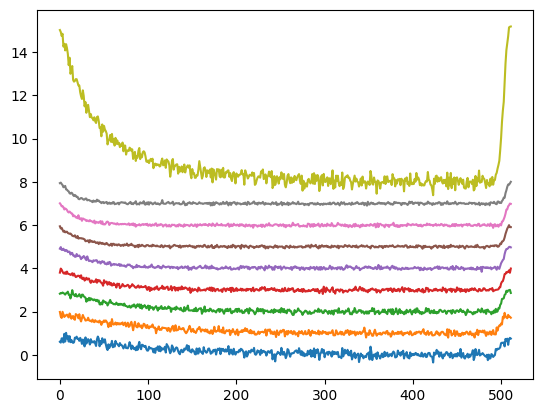

Ndim = 13

Parameter names: ['Sw', 'Phi', 'A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'DM', 'Tau_1', 'Tau_idx']
Creating directory for new run /project/gravwave/Data/TPASCAT/nested_runs/J1818-1422_2020-03-29-04:45:36_zap_chopped.16ch_1p_1t_13/run3
Sampler initialized with log directory: /project/gravwave/Data/TPASCAT/nested_runs/J1818-1422_2020-03-29-04:45:36_zap_chopped.16ch_1p_1t_13
Sampler initialized with parameters: ['Sw', 'Phi', 'A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'DM', 'Tau_1', 'Tau_idx']
Running sampler with 200 live points...
[ultranest] Sampling 200 live points from prior ...
[ultranest] Explored until L=-2e+01   [-25.5283..-25.5280]*| it/evals=4299/57376 eff=7.5189% N=200    
[ultranest] Likelihood function evaluations: 57376
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -42.23 +- 0.209
[ultranest] Effective samples strategy satisfied (ESS = 1303.5, need >400)
[ultranest] Post

In [7]:
json_dir = "/project/gravwave/Data/TPASCAT/jsons/"
json_files = [os.path.join(json_dir, f) for f in os.listdir(json_dir) if f.endswith(".json")]
results_path = "/project/gravwave/Data/TPASCAT/Scat_Results"
process_pulsar(json_files[3],results_path)
# Run the batch processing
#batch_process_pulsars(json_files, results_path)